# Synthetic inversion

## import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

from RIS_gravity_inversion import plotting
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt

import os

PROJ: proj_create_from_database: Cannot find proj.db


# Set region and parameters

In [2]:
# set grid parameters
registration = "g"

# same as RIS gravity inversion region
RIS_inv_region = [-580e3, 420e3, -1420e3, -420e3]

inversion_region, buffer_region = utils.alter_region(
    RIS_inv_region,
    zoom=350e3,
    n_shift=50e3,
    w_shift=0e3,
    buffer=50e3,
)

print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

inversion region =  [-230000.0, 70000.0, -1120000.0, -820000.0]
buffer region =  [-280000, 120000, -1170000, -770000]


# Prep for the inversion

## load synthetic layers and full gravity grid

In [3]:
layer1 = xr.open_zarr("../synthetic_data/synthetic_layer1.zarr").z

layer2 = xr.open_zarr("../synthetic_data/synthetic_layer2.zarr").z

layer3 = xr.open_zarr("../synthetic_data/synthetic_layer3.zarr").z

synthetic_gravity = xr.open_zarr("../synthetic_data/synthetic_forward_grav.zarr")

starting_bathymetry = xr.open_zarr(
    "../synthetic_data/synthetic_starting_bathymetry.zarr"
)["z"]

print(utils.get_grid_info(starting_bathymetry))
starting_bathymetry

c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


(1000.0, [-280000.0, 120000.0, -1170000.0, -770000.0], -918.70135498, -452.081481934, 'g')


<xarray.DataArray 'z' (y: 401, x: 401)>
dask.array<open_dataset-d7981290dc859e4aa905015ce605c95bz, shape=(401, 401), dtype=float32, chunksize=(201, 401), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -2.8e+05 -2.79e+05 -2.78e+05 ... 1.19e+05 1.2e+05
  * y        (y) float64 -1.17e+06 -1.169e+06 -1.168e+06 ... -7.71e+05 -7.7e+05
Attributes:
    actual_range:  [-918.7013549804688, -452.08148193359375]
    long_name:     z

## make a new layers dict
Note, this doesn't include Layer3 (the regional field) or the full-resolution bathymetry. This is so we can test whether the inversion is seperating the regional properly, and recovering the true bathymetry

In [4]:
active_layer = "bathymetry"

grav_spacing = 5e3

returned = inv_utils.import_layers(
    layers_list=[
        "water",
        "bathymetry",
    ],
    spacing_list=[
        5e3,
        5e3,
    ],
    rho_list=[
        1030,
        2300,
    ],
    fname_list=[
        "../synthetic_data/synthetic_layer1.zarr",
        "../synthetic_data/synthetic_starting_bathymetry.zarr",
    ],
    grav_file="../synthetic_data/synthetic_gravity.csv.gz",
    constraint_points="../synthetic_data/synthetic_constraints.csv.gz",
    grav_spacing=grav_spacing,
    active_layer=active_layer,
    buffer_region=buffer_region,
    inversion_region=inversion_region,
    registration=registration,
    # kwargs
    block_reduction="pygmt",
    input_grav_name="free_air_anomaly",
    input_obs_height_name="ellipsoidal_elevation",
    subset_constraints=False,
)
(
    inv_layers,
    grav,
    constraint_grid,
    constraint_points,
    constraint_points_subset,
) = returned

Block-reduced the gravity data at 5000m spacing
from 6600 points to 1257 points

********************Resampling water layer ********************
spacing larger than original, filtering and resampling
water info: (5000.0, [-280000.0, 120000.0, -1170000.0, -770000.0], -350.0, -350.0, 'g')

********************Resampling bathymetry layer ********************
spacing larger than original, filtering and resampling
bathymetry info: (5000.0, [-280000.0, 120000.0, -1170000.0, -770000.0], -897.260314941, -459.371551514, 'g')
gravity: 1257 points
gravity avg. elevation: 1000
bathymetry control points:33


## plot inputs

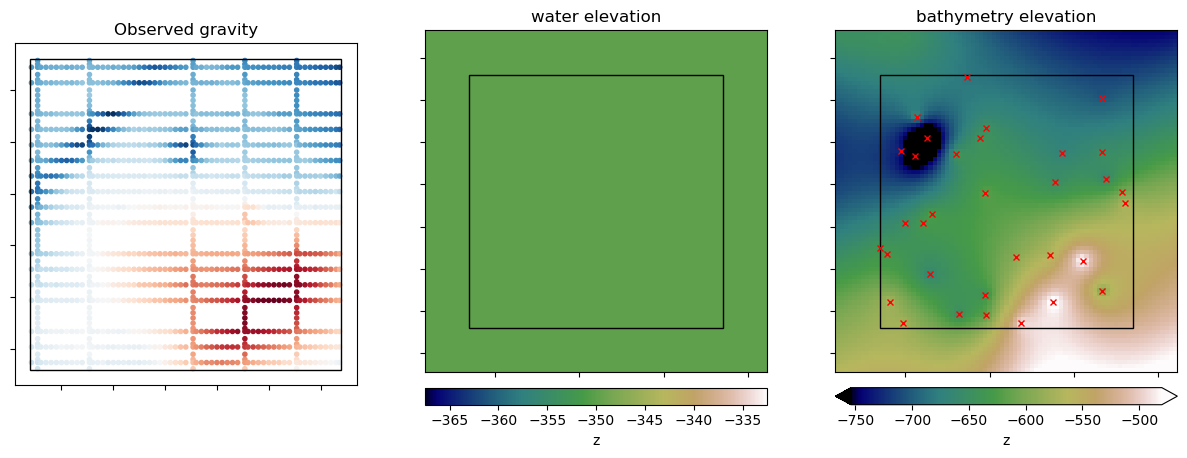

In [5]:
plotting.plot_inputs(
    returned,
    grav_spacing=grav_spacing,
    active_layer=active_layer,
    region=buffer_region,
    inversion_region=inversion_region,
    # plot_type='pygmt', # 54 secs
    plot_type="xarray",  # 2.1 secs
    # kwargs
    plotting_constraints=constraint_points,
)

# Invert to recover full-res starting model

## make prism layers

********** bathymetry top: -628m and bottom: -897m **********
********** water top: -350m and bottom: -628m **********



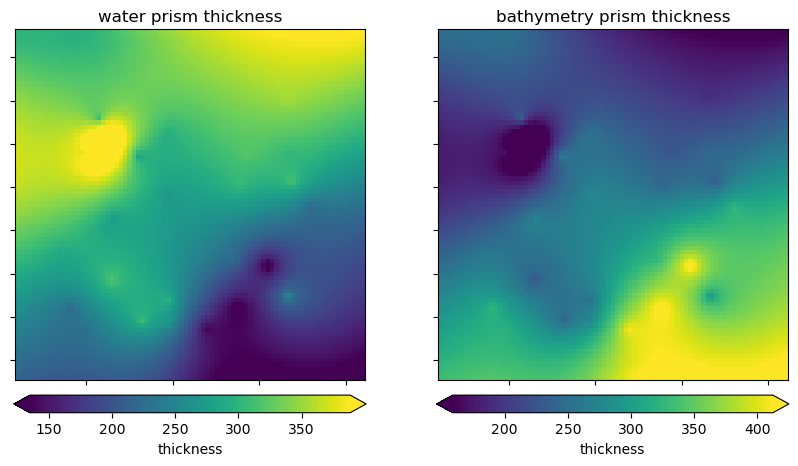

In [6]:
inv.grids_to_prism_layers(
    inv_layers,
    # thickness_threshold=100,
    registration=registration,
)

plotting.plot_prism_layers(
    inv_layers,
    cmap="viridis",
    # plot_type='3D',
    layers_for_3d=[active_layer],
    # color_by='density',
    color_by="thickness",
    clip_box=False,
    log_scale=False,
)

## forward gravity

  0%|          | 0/1257 [00:00<?, ?it/s]

6561 prisms in water layer
finished water layer


  0%|          | 0/1257 [00:00<?, ?it/s]

6561 prisms in bathymetry layer
finished bathymetry layer


,x,y,Gobs,z,water_forward_grav,bathymetry_forward_grav,forward_total
count,1257.000000,1.257000e+03,1257.000000,1257.0,1.257000e+03,1.257000e+03,1.257000e+03
mean,-82146.778043,-9.699113e+05,0.000000,1000.0,-3.617720e-16,-3.617720e-15,-3.617720e-15
std,88972.738657,8.682755e+04,8.844619,0.0,2.637331e+00,5.886442e+00,3.249977e+00
min,-229000.000000,-1.119000e+06,-18.120663,1000.0,-6.770269e+00,-1.980004e+01,-1.091333e+01
25%,-165000.000000,-1.038000e+06,-6.750308,1000.0,-1.497082e+00,-4.020414e+00,-2.262491e+00
50%,-73000.000000,-9.630000e+05,-0.697039,1000.0,3.274390e-01,-6.704427e-01,-3.362753e-01
75%,-5000.000000,-9.030000e+05,5.765922,1000.0,1.760580e+00,3.394241e+00,1.892502e+00
max,68500.000000,-8.215000e+05,21.940168,1000.0,8.886708e+00,1.511037e+01,8.340100e+00


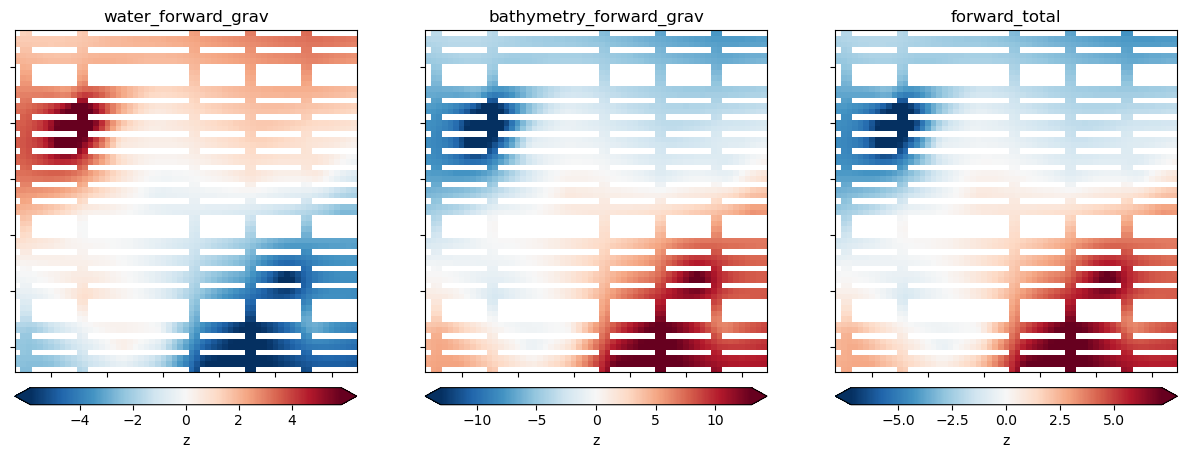

In [7]:
df_forward = inv.forward_grav_layers(
    inv_layers,
    grav,
    progressbar=True,
    parallel=True,
)

forward_grids = plotting.forward_grav_plotting(
    df_forward,
    region=inversion_region,
    grav_spacing=grav_spacing,
    # kwargs
    # plot_dists = True,
)

df_forward.describe()

## anomalies

The `observed gravity` is the combination of the signal from the `bathymetry` (sediment-water contact) and the `crust` (sediment-basement contact). While both of these fields have a long-wavelength components, almost all of the short-wavelength signal is resulting from the bathymetry. We need to ensure when we invert for the bathymetry, we aren't including a residual signal coming from unknown crustal structures. 

To do this, we need to accurately seperate the `regional` field from the forward-observed gravity misfit. This `regional` field should theoretically contain every gravity signal other than the that resulting from the bathymetry surface. 

Here, since we precisely know the regional component (the forward gravity of Layer 3), we can tune our regional-residual seperation method. 

### load the true regional gravity anomaly

spacing larger than original, filtering and resampling


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


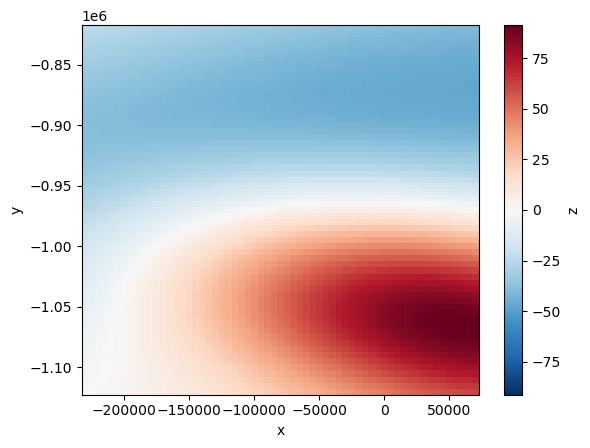

In [9]:
true_regional = fetch.resample_grid(
    synthetic_gravity.layer3_forward_grav,
    region=inversion_region,
    spacing=grav_spacing,
    registration=registration,
)

true_regional.plot()

### optimize the regional-residual seperation

We have 4 methods to seperate the regional misfit from the residual misfit.
1) Filter method: Apply a low-pass filter to the misfit
2) Trend method: Fit a trend to the misfit
3) Constraints method: Sample and grid the misfit only at constraint points, where we know the true layer depth
4) Equivalent-Sources method: Predict the gravity anomaly resulting from a serious of deep sources.

Each of these methods has 1 parameter to tune. Respectively, this are 
1) gaussian low-pass filter width (1km - 1000km)
2) trend order (1 - 20)
3) gridding tension factor (0 - 1)
4) source depth (10km - 10,000km)

The optimization will explore the parameter space of each of these, and return the parameters which result in a regional msifit closest to the true layer 3 forward gravity. 


Choose to either run all 4 methods in the same optimization, or run each seperately. 

In [64]:
kwargs = dict(
    true_regional=true_regional,
    layers=inv_layers,
    input_grav=df_forward,
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    constraints=constraint_points,
)

#### Optimize 4 methods together

In [75]:
study, method = inv_utils.optimize_regional_together(100, **kwargs)

Best result: {'method': 'constraints', 'param': 0}



########## constraints ##########
params_param            0
value           33.802247
Name: 85, dtype: object
returning original grid
returning original grid


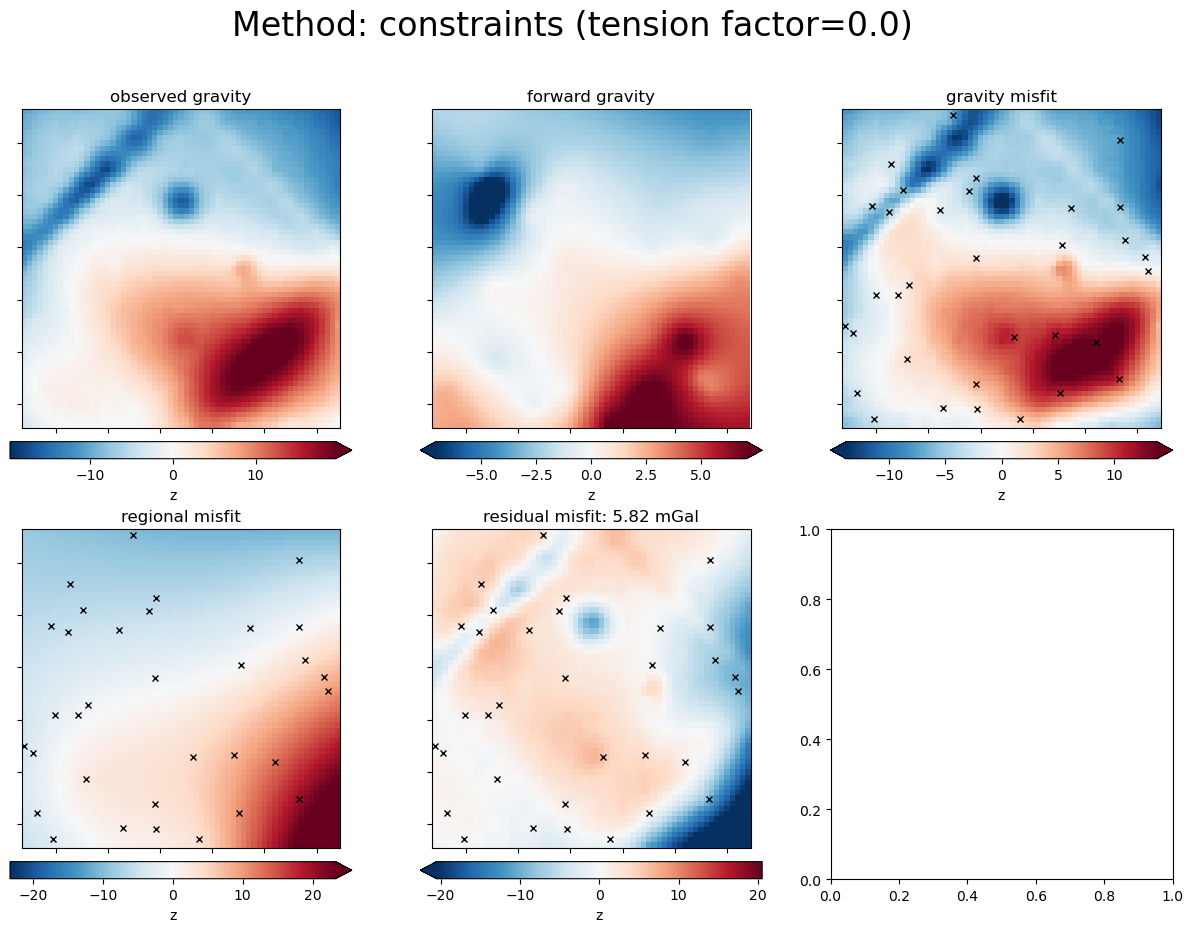

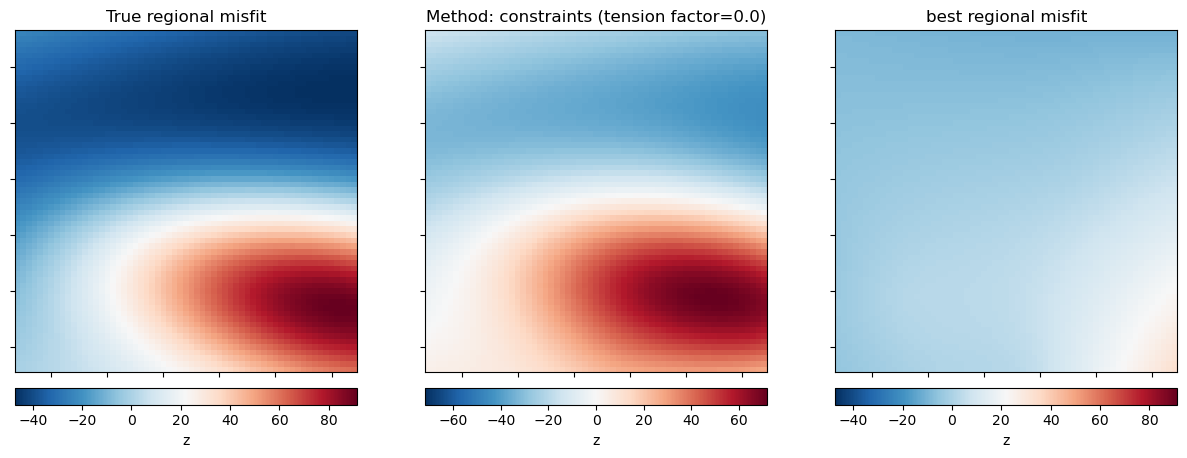

In [80]:
inv_utils.plot_best_param(study, method, **kwargs)

#### Optimize methods individually

In [81]:
studies = inv_utils.optimize_regional_loop(20, **kwargs)

Method: filter, best result: {'param': 31000}


Method: trend, best result: {'param': 10}


Method: constraints, best result: {'param': 0}


Method: eq_sources, best result: {'param': 2180000}



########## filter ##########
params_param        31000
value           35.253524
Name: 11, dtype: object
returning original grid
returning original grid

########## trend ##########
params_param           10
value           35.203418
Name: 0, dtype: object
returning original grid
returning original grid

########## constraints ##########
params_param            0
value           33.802247
Name: 2, dtype: object
returning original grid
returning original grid

########## eq_sources ##########
params_param      2180000
value           35.250669
Name: 19, dtype: object
returning original grid
returning original grid


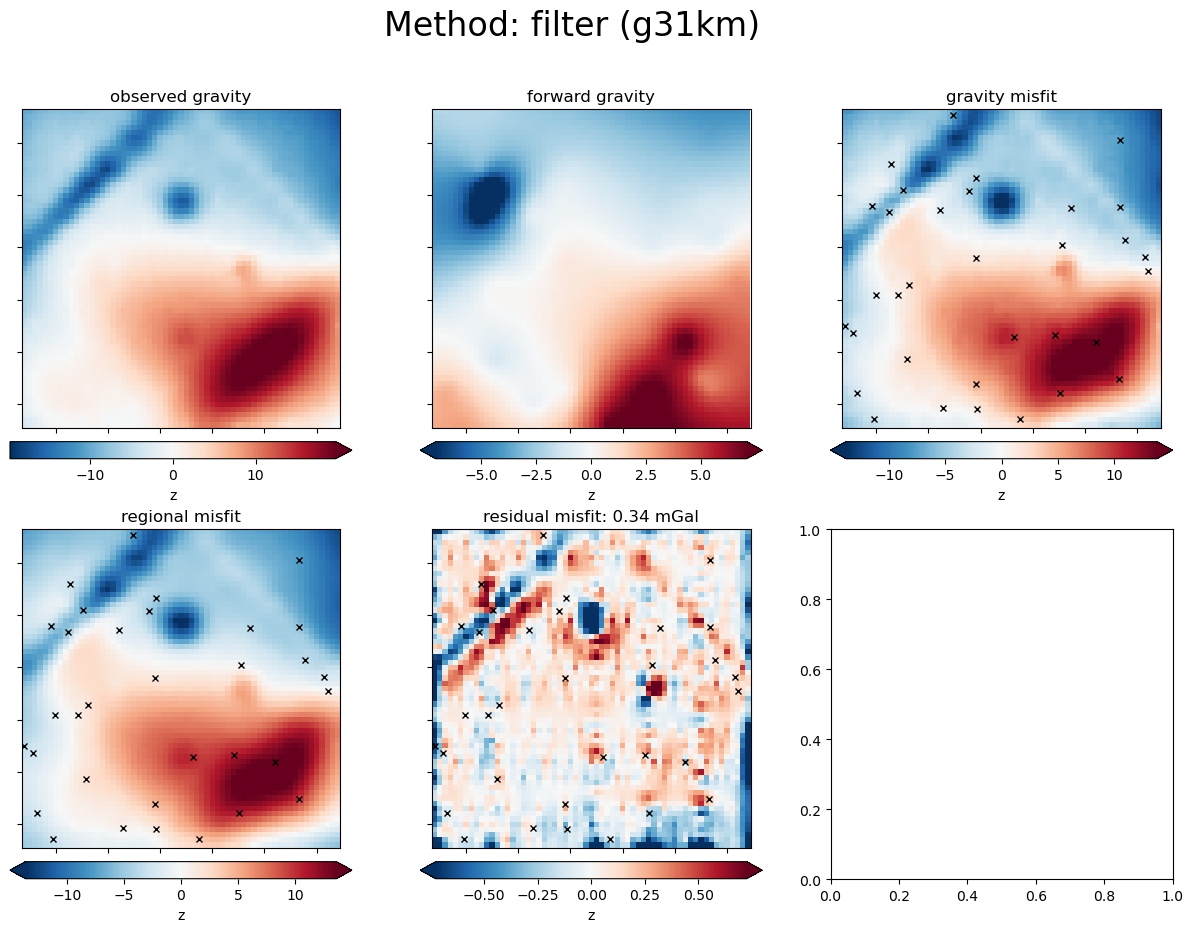

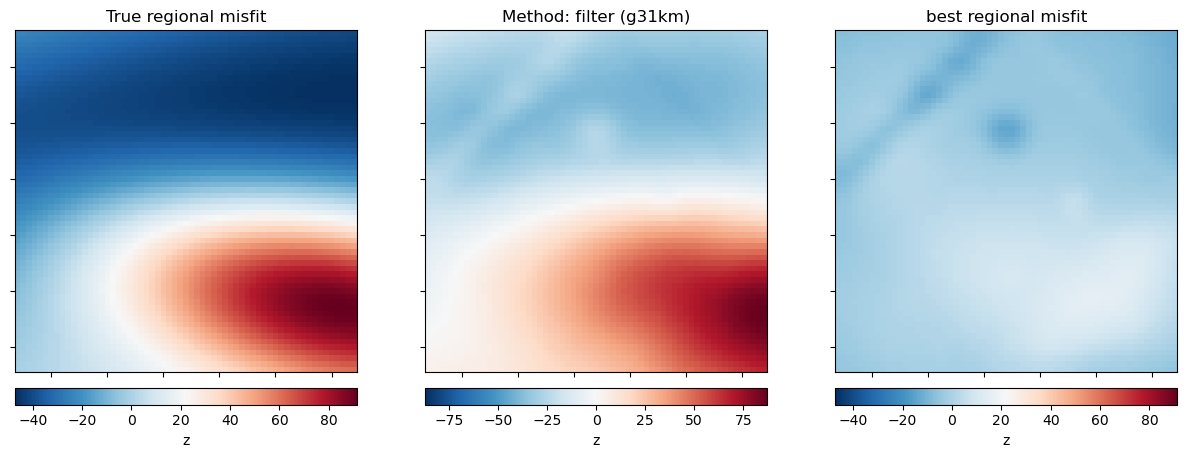

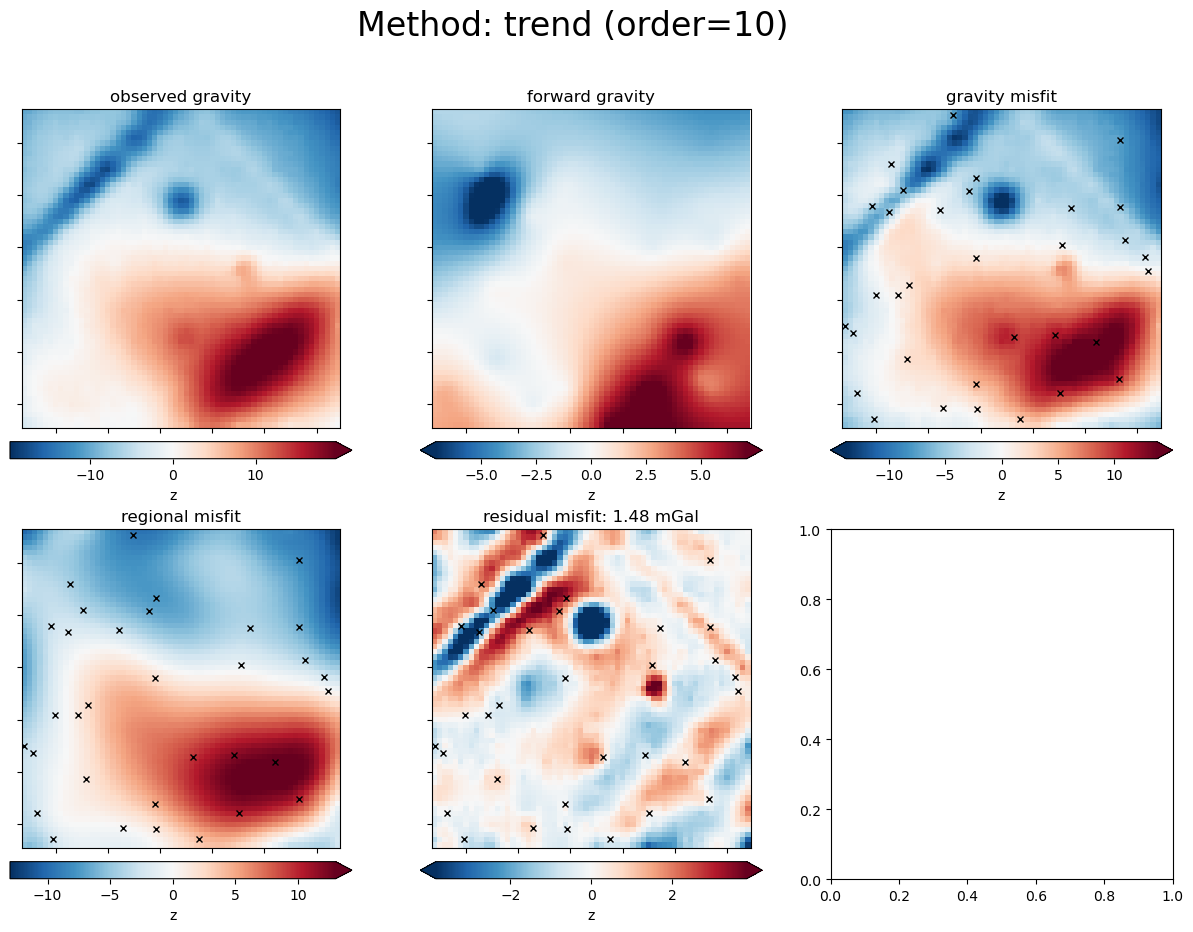

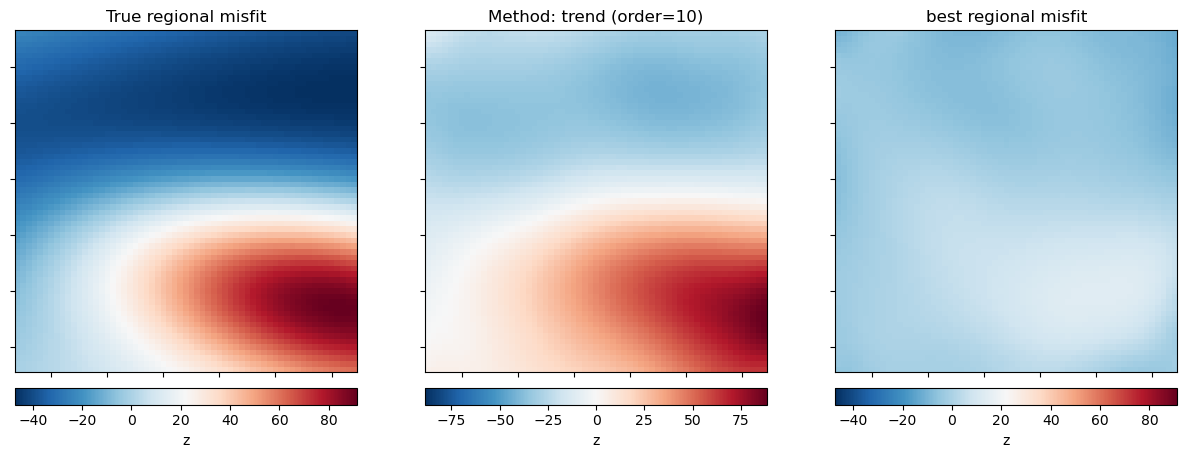

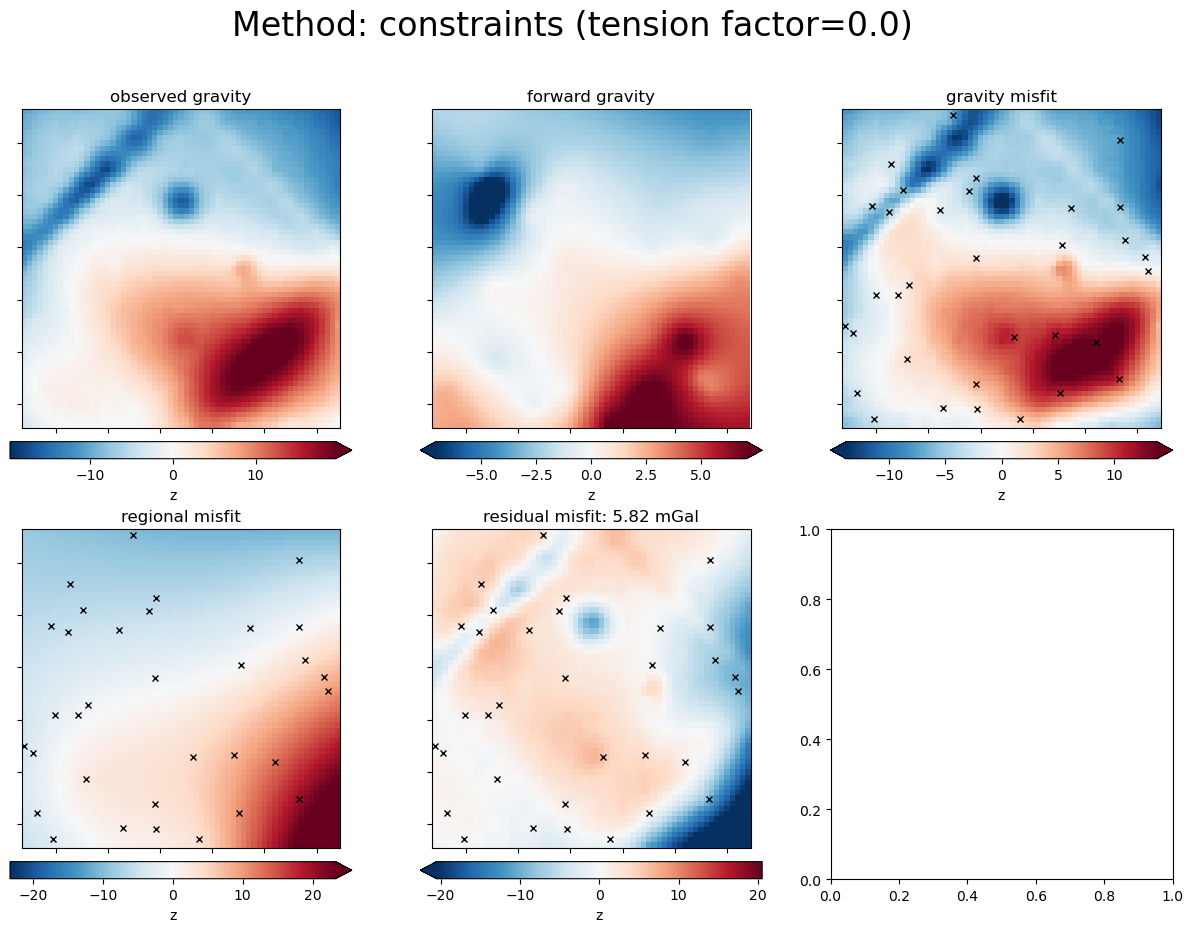

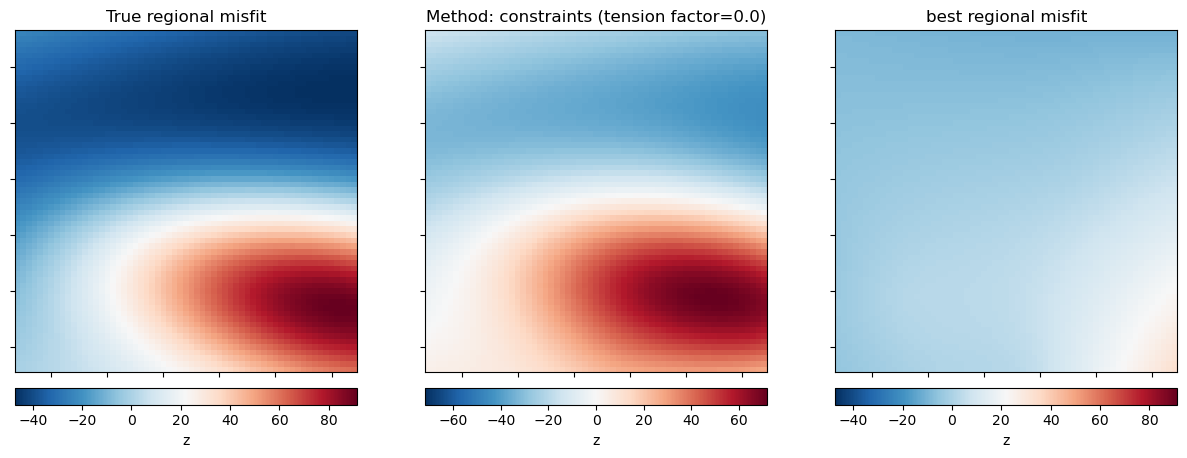

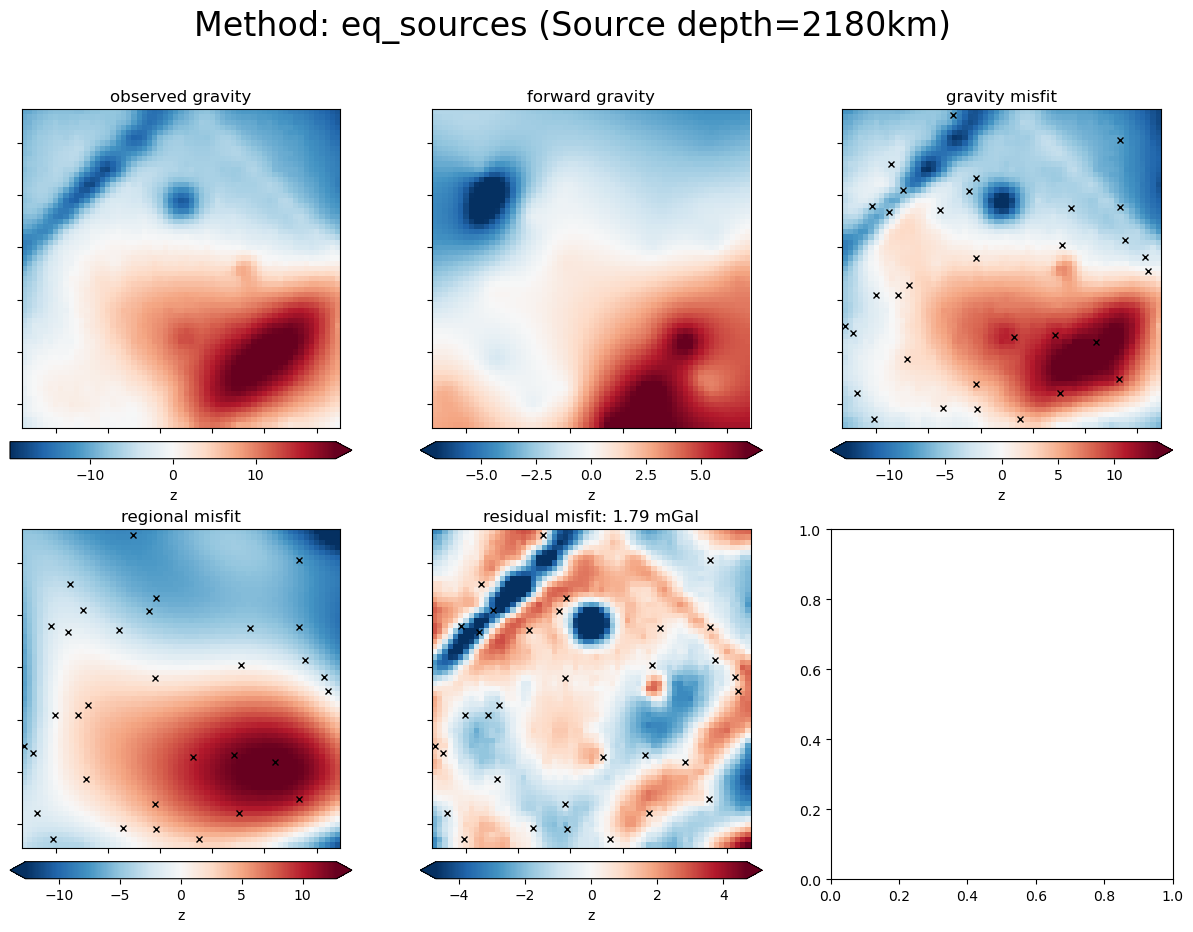

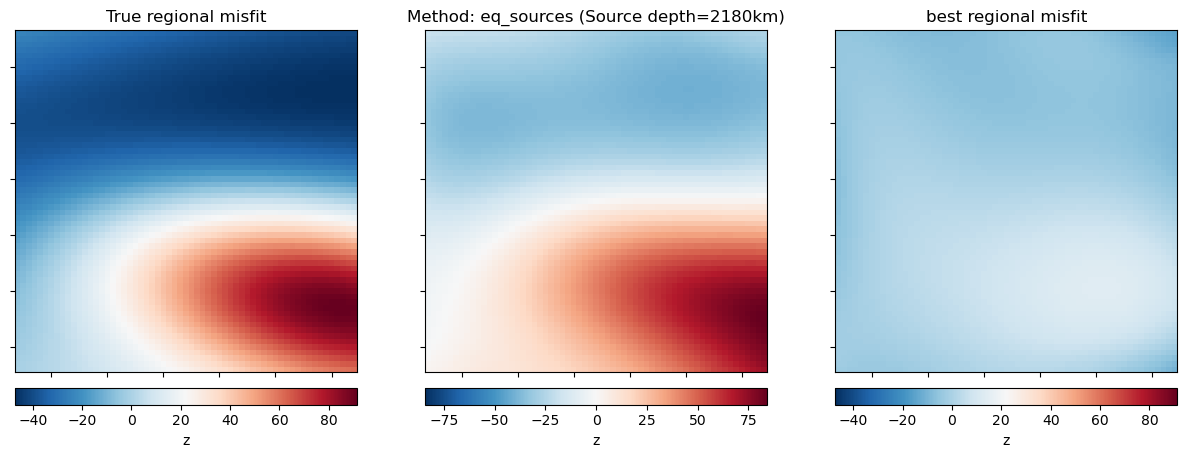

In [82]:
inv_utils.plot_best_params_per_method(studies, **kwargs)

In [86]:
filter = "g31e3"
trend = 10
tension = 0
eq_sources = 2180e3

# regional_method="filter"
# title= f"Method: {regional_method} (g{int(filter/1e3)}km)"

# regional_method="trend"
# title= f"Method: {regional_method} (order={trend})"

regional_method = "constraints"
title = f"Method: {regional_method} (tension factor={tension/10})"

# regional_method = "eq_sources"
# title = f"Method: {regional_method} (Source depth={int(eq_sources/1e3)}km)"

,x,y,Gobs,z,water_forward_grav,bathymetry_forward_grav,forward_total,grav_corrected,misfit,reg,res
count,1257.000000,1.257000e+03,1257.000000,1257.0,1.257000e+03,1.257000e+03,1.257000e+03,1257.000000,1.257000e+03,1257.000000,1257.000000
mean,-82146.778043,-9.699113e+05,0.000000,1000.0,-3.617720e-16,-3.617720e-15,-3.617720e-15,0.000000,3.617720e-15,0.423536,-0.423536
std,88972.738657,8.682755e+04,8.844619,0.0,2.637331e+00,5.886442e+00,3.249977e+00,8.844619,6.223934e+00,7.908564,5.809612
min,-229000.000000,-1.119000e+06,-18.120663,1000.0,-6.770269e+00,-1.980004e+01,-1.091333e+01,-18.120663,-1.564475e+01,-10.756152,-36.730264
25%,-165000.000000,-1.038000e+06,-6.750308,1000.0,-1.497082e+00,-4.020414e+00,-2.262491e+00,-6.750308,-4.482310e+00,-5.164570,-1.552943
50%,-73000.000000,-9.630000e+05,-0.697039,1000.0,3.274390e-01,-6.704427e-01,-3.362753e-01,-0.697039,-7.505662e-01,-1.196169,0.657730
75%,-5000.000000,-9.030000e+05,5.765922,1000.0,1.760580e+00,3.394241e+00,1.892502e+00,5.765922,3.895314e+00,3.555040,3.275443
max,68500.000000,-8.215000e+05,21.940168,1000.0,8.886708e+00,1.511037e+01,8.340100e+00,21.940168,1.547245e+01,31.911504,7.131697


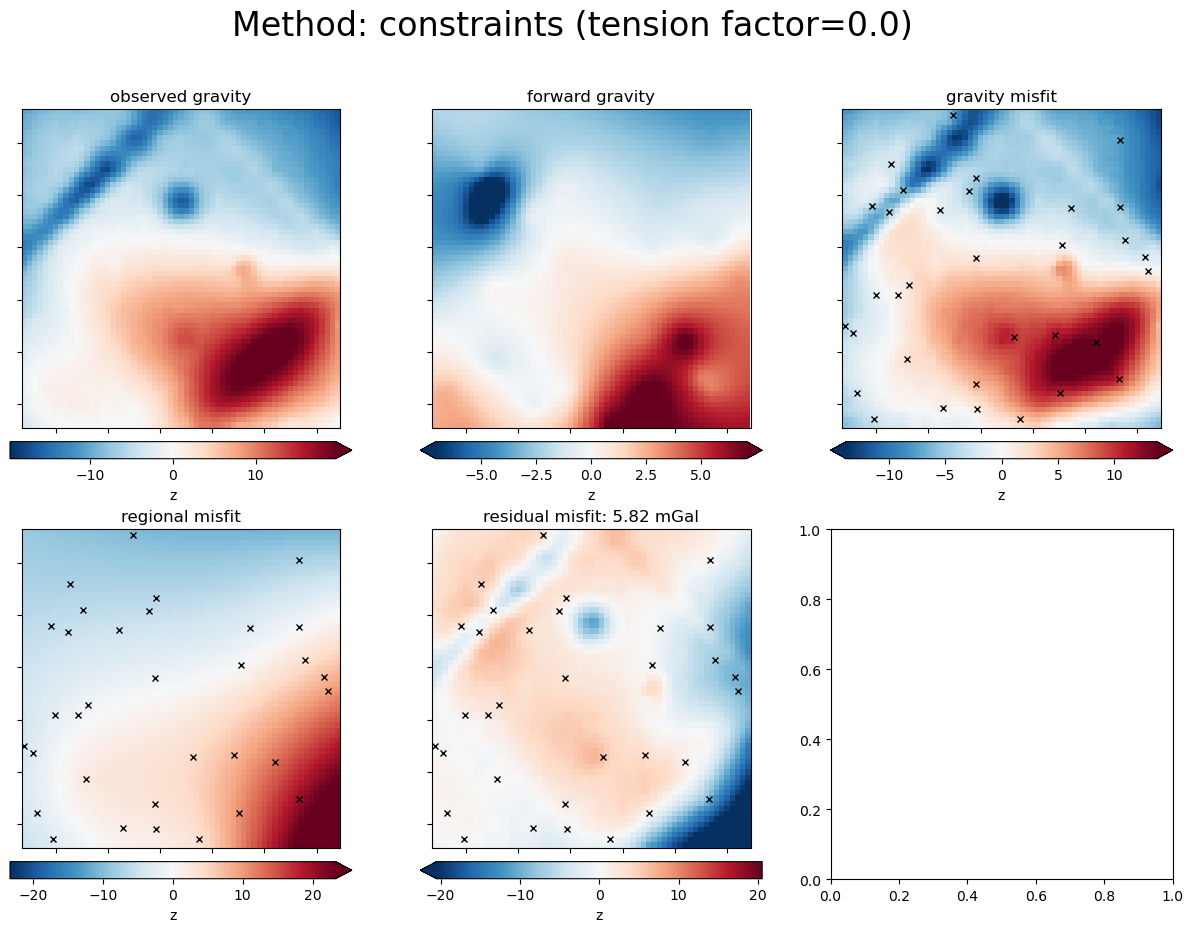

In [87]:
df_anomalies = inv.anomalies(
    layers=inv_layers,
    input_grav=df_forward,
    grav_spacing=grav_spacing,
    registration=registration,
    regional_method=regional_method,
    crs="3031",
    # KWARGS
    inversion_region=inversion_region,
    # filter kwargs
    filter=filter,
    # trend kwargs
    trend=trend,
    fill_method="pygmt",
    # fill_method='rioxarray',
    # constraint kwargs
    constraints=constraint_points,
    tension_factor=tension,
    # eq sources kwargs
    eq_sources=eq_sources,
    depth_type="relative",
    eq_damping=None,
    block_size=grav_spacing,
)

anom_grids = plotting.anomalies_plotting(
    df_anomalies,
    region=inversion_region,
    grav_spacing=grav_spacing,
    title=title,
    constraints=constraint_points,
    # plot_dists=True,
    # plot_power_spectrums=True,
)

df_anomalies.describe()

## inversion

In [88]:
# %%snakeviz --new-tab

topo_results, grav_results, layers_update = inv.geo_inversion(
    active_layer=active_layer,
    layers_dict=inv_layers,
    input_grav=df_forward,
    # input_grav=df_anomalies,
    buffer_region=buffer_region,
    regional_method=regional_method,
    grav_spacing=grav_spacing,
    l2_norm_tolerance=1,
    delta_l2_norm_tolerance=0.1,
    max_iterations=3,
    # registration="g",
    # deriv_type="annulus",
    deriv_type="prisms",
    # solver_type="least squares",
    solver_type="verde least squares",  # issue with top row, values to extreme
    # solver_type="steepest descent",
    # solver_type="gauss newton",
    # solver_damping=1e3,
    # apply_weights=True,
    # max_layer_change_per_iter=200,
    # save_results = True,
    # kwargs
    apply_constraints=False,
    # filter kwargs
    filter=filter,
    # trend kwargs
    trend=trend,
    fill_method="pygmt",
    # fill_method='rioxarray',
    # constraint kwargs
    constraints=constraint_points,
    tension_factor=tension,
    # eq sources kwargs
    eq_sources=eq_sources,
    depth_type="relative",
    eq_damping=None,
    block_size=grav_spacing,
    # fname_topo = "topo_results_5k_constraints_base",
    # fname_gravity = "gravity_results_5k_constraints_base",
)
#  45s, 52s,

xyz2grd [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
xyz2grd [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
xyz2grd (gmtapi_init_grdheader): Please select compatible -R and -I values
grdtrack [WARNING]: Some input points were outside the grid domain(s).
blockmedian [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
blockmedian [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
blockmedian (gmtapi_init_grdheader): Please select compatible -R and -I values



##############################################################################################
iteration 1
initial misfit RMSE = 7.2 mGal
initial L2-norm : 2.68
initial delta L2-norm : inf


c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\verde\base\least_squares.py:57: UserWarning:

Under-determined problem detected (ndata, nparams)=(1257, 6561).



Layer correction mean: -1294 m, RMSE: 13306 m
constraints not applied


xyz2grd [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
xyz2grd [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
xyz2grd (gmtapi_init_grdheader): Please select compatible -R and -I values


updating the misfits


grdtrack [WARNING]: Some input points were outside the grid domain(s).
blockmedian [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
blockmedian [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
blockmedian (gmtapi_init_grdheader): Please select compatible -R and -I values



updated misfit RMSE: 61.14
updated L2-norm: 7.82,  tolerance: 1
updated delta L2-norm : 0.34,  tolerance: 0.1

##############################################################################################
iteration 2
initial misfit RMSE = 61.14 mGal
initial L2-norm : 7.82
initial delta L2-norm : 0.34


c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\verde\base\least_squares.py:57: UserWarning:

Under-determined problem detected (ndata, nparams)=(1257, 6561).



Layer correction mean: -29633 m, RMSE: 530732 m
constraints not applied


xyz2grd [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
xyz2grd [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
xyz2grd (gmtapi_init_grdheader): Please select compatible -R and -I values


updating the misfits


grdtrack [WARNING]: Some input points were outside the grid domain(s).
blockmedian [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
blockmedian [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
blockmedian (gmtapi_init_grdheader): Please select compatible -R and -I values



updated misfit RMSE: 467.4
updated L2-norm: 21.62,  tolerance: 1
updated delta L2-norm : 0.36,  tolerance: 0.1

##############################################################################################
iteration 3
initial misfit RMSE = 467.4 mGal
initial L2-norm : 21.62
initial delta L2-norm : 0.36


c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\verde\base\least_squares.py:57: UserWarning:

Under-determined problem detected (ndata, nparams)=(1257, 6561).



Layer correction mean: 1145375 m, RMSE: 165390138 m
constraints not applied


xyz2grd [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
xyz2grd [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
xyz2grd (gmtapi_init_grdheader): Please select compatible -R and -I values


updating the misfits


grdtrack [WARNING]: Some input points were outside the grid domain(s).
blockmedian [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
blockmedian [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
blockmedian (gmtapi_init_grdheader): Please select compatible -R and -I values



updated misfit RMSE: 716.55
updated L2-norm: 26.77,  tolerance: 1
updated delta L2-norm : 0.81,  tolerance: 0.1

Inversion terminated after 3 iterations with L2-norm = 26.77 because maximum number of iterations  (3) reached


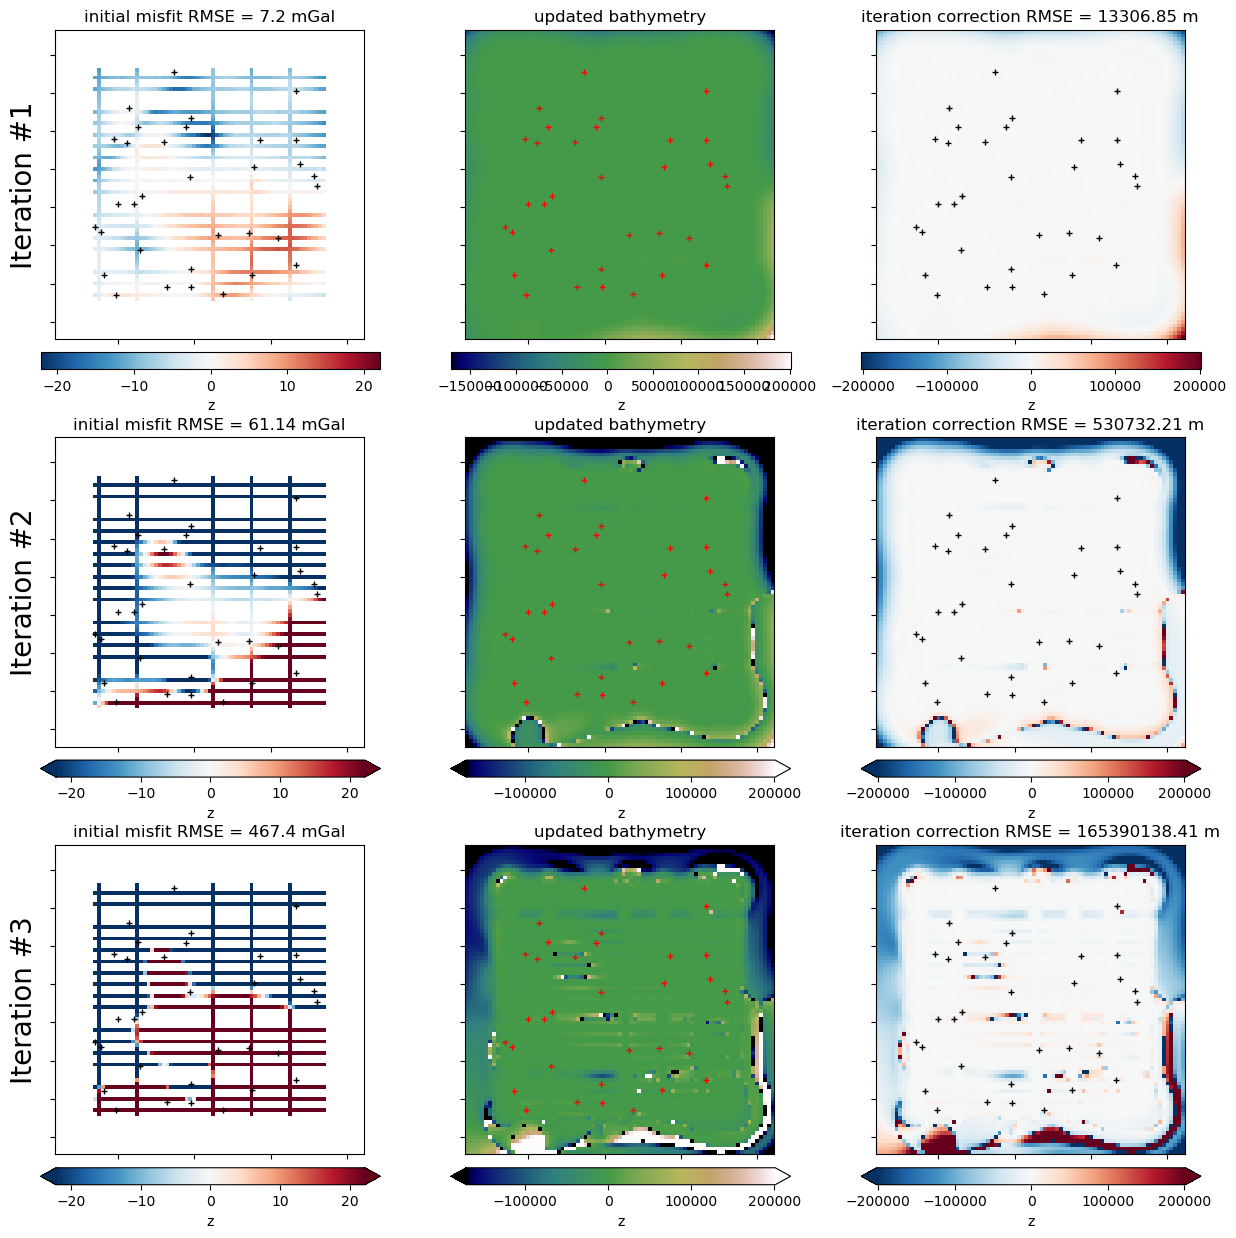

In [89]:
plotting.plot_inversion_results(
    grav_results=grav_results,
    topo_results=topo_results,
    layers_dict=inv_layers,
    active_layer=active_layer,
    grav_spacing=grav_spacing,
    region=buffer_region,
    # registration="g",
    # plot_iters = False,
    plot_topo_results=False,
    plot_grav_results=False,
    # kwargs
    constraints=constraint_points,
)

## compare inverted bathymetry to synthetic starting bathymetry

In [ ]:
layers_update[active_layer]["prisms"].top.plot(robust=True)

In [ ]:
grids = utils.grd_compare(
    layer2,
    layers_update[active_layer]["prisms"].top,
    region=inversion_region,
    plot=True,
    plot_type="xarray",
)

In [ ]:
def ackley(x, y):
    return (
        -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
        - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
        + np.exp(1)
        + 20
    )


# Create gridded data
INC = 0.05
x = np.arange(-5, 5 + INC, INC)
y = np.arange(-5, 5 + INC, INC)
data = xr.DataArray(ackley(*np.meshgrid(x, y)), coords=(x, y))
data